# Searching for Cinderella
We naturally root for the underdogs, and when they score the upset, we are extremely quick to put forth all the euphemysms imaginable. But, the NCAA Basketball Tournament has a language of its own. March Madness (tm) loves it's Cinderellas.

Ok, I like analogies, so assuming we are Prince Charming, let's talk how we can find Cinderella before the clock strikes midnight. And for good measure, lets see if we can fit in the rest of the analogy with the Evil Step-sisters (one has to be Duke right?), Fairy Godmother (Gus Johnson?), and the pumpkin carriage (uh... sure).

So how does one define a "Cinderella." It seems fairly open to interpretation, but really is about some label of upsets.

In [1]:
# Import our libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
carolinaBlue = 'deepskyblue'  # because d00k sucks

In [2]:
# import files for data exploration
folder = "2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/"

# kaggle provided files
DetailedResults = pd.read_csv(folder + "MNCAATourneyDetailedResults.csv")
teams = pd.read_csv(folder + "MTeams.csv")
historical_seeds = pd.read_csv(folder + "MNCAATourneySeeds.csv")
rounds = pd.read_csv(folder + "MNCAATourneySeedRoundSlots.csv")
Results = pd.read_csv(folder + "MNCAATourneyCompactResults.csv")
df_Seeds = pd.read_csv(folder + "MNCAATourneySeeds.csv")

# self-created/ web-scraped
program_success = pd.read_csv("CreatedData/TourneyHistory.csv")
sponsorships = pd.read_csv("CreatedData/MTeams_Detailed.csv")


# Data Exploration
As this is notebook dedicated to data exploration, we're going to organize it based on the subject of our exploration


# The Straight Forward Visualizations

- program success: top 25 schools by % participation rate in NCAA Championships
- program strength:  average seed of those schools
- sponsorship
- Does Seeding Matter?

Who are the top 25 most successful Men's Basketball Programs?

In [3]:
top_25 = program_success.head(25).sort_values('# Tourneys', ascending = True)
total_years =  2019-1984 # our data goes  from the '84/85 season to the '18/19 season

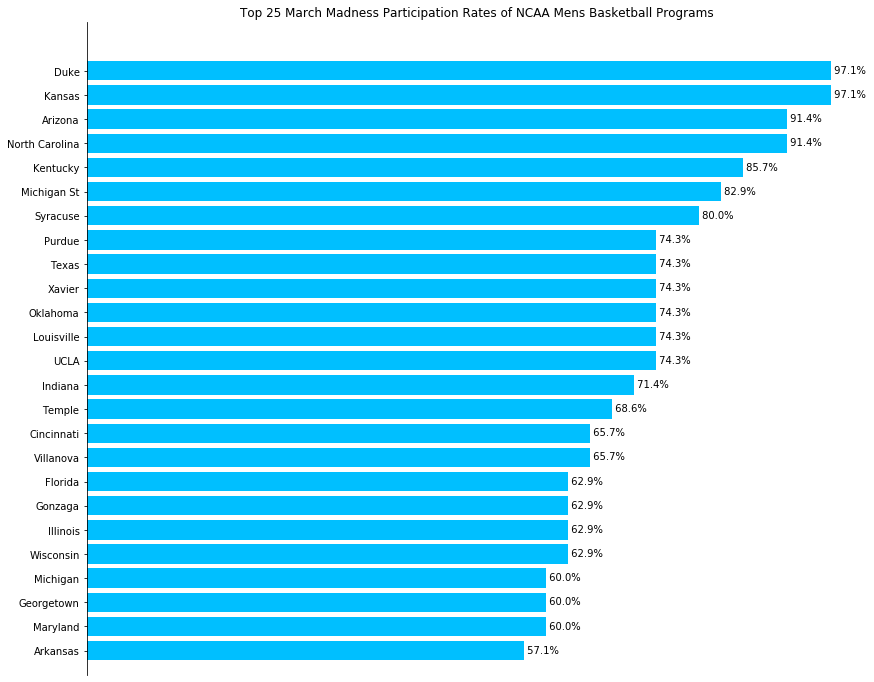

In [4]:
top_25 = top_25.sort_values('# Tourneys', ascending = True)

plt.figure(figsize=(14,12))
plt.barh(top_25['TeamName'], top_25['# Tourneys'], color = carolinaBlue)

sns.despine(bottom=True)
plt.xticks([])
plt.ylim(-1,26)

plt.title('Top 25 March Madness Participation Rates of NCAA Mens Basketball Programs')

for i, v in enumerate(top_25['# Tourneys']):
    plt.text(v+0.003, i - 0.1, f' {str(round(v*100/total_years,1))}%', fontsize = 10)

What is the average seed these top 25 programs recieve 

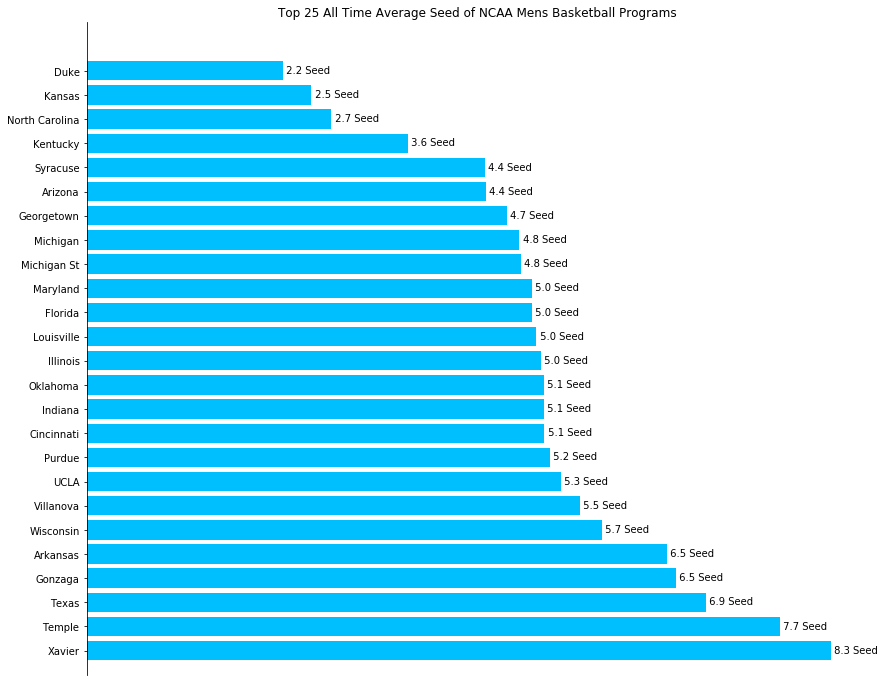

In [5]:
top_25 = top_25.sort_values('Average Seed', ascending = False)

plt.figure(figsize=(14,12))
plt.barh(top_25['TeamName'], top_25['Average Seed'], color = carolinaBlue)

sns.despine(bottom=True)
plt.xticks([])
plt.ylim(-1,26)

plt.title('Top 25 All Time Average Seed of NCAA Mens Basketball Programs')

for i, v in enumerate(top_25['Average Seed']):
    plt.text(v+0.003, i - 0.1, f' {str(round(v,1))} Seed', fontsize = 10)

# Sponsorships
Lets extrapolate schools for their sponsors and rerank our schools

Sponsor data was hand collected and collated. Most data collections are woefully incomplete, and sometimes out of date. So sponsors were discovered through image search for recent in game photos and identifying logo on team jersey.

For simplicity's sake and complete lack of information.
Sponsors are assigned to each team for the 2019-2020 season, but counts as the same sponsor for all seasons they have been participating in the tournament.

In [6]:
# what is the sponsorship breakdown of all D1 NCAA Men's Basketball Teams?

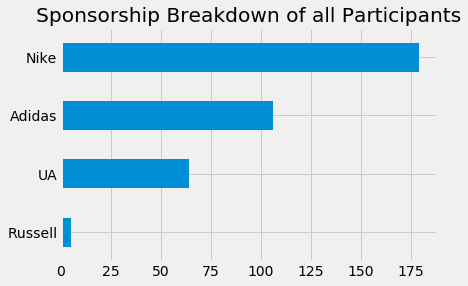

In [7]:

plt.style.use('fivethirtyeight')

sponsorships.Sponsor.value_counts() \
                    .sort_values() \
                    .plot(kind='barh', title = "Sponsorship Breakdown of all Participants")
plt.show()

lets merge this with our top 25 list

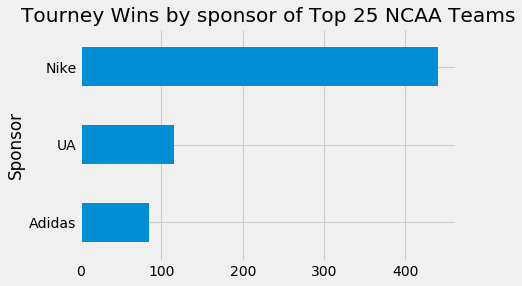

In [8]:

seedSponsor = top_25.merge(sponsorships[['TeamID', 'Sponsor']], on='TeamID', how='left')
plt.style.use('fivethirtyeight')
seedSponsor.groupby('Sponsor')['# Tourneys'] \
            .sum() \
            .sort_values() \
            .plot(kind='barh', title = "Tourney Wins by sponsor of Top 25 NCAA Teams")
plt.show()

Ok, that was fun, but ultimately useless.  Let's ask some real questions now.

# Does Seeding Matters?

lets look at the relationship between seeding and point differentials.

In [9]:
df_Seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [10]:
# we need a quick and dirty function to convert Seed from its current format to an int.
 
def convertSeed(seed):
    '''Convert Seed from String to Int.
     so "W01" --> is 1, with the advent of the play in games, 
     we only care about 2nd and 3rd positions in the string.'''
    
    return (int(seed[1:3]))

In [21]:
# the other function we need is converting the DayNum of the tourney to its corresponding round of action.

def convertRound(DayNum):
    '''
    Convert DayNum to appropriate tournament round.   Play-In Games counted as 0, Round 1 as 1, etc.
    '''
    
    if (DayNum == 134) | (DayNum == 135):
        return 68
    elif (DayNum == 136) | (DayNum == 137):
        return 64
    elif (DayNum == 138) | (DayNum == 139):
        return 32
    elif (DayNum == 143) | (DayNum == 144):
        return 16
    elif (DayNum == 145) | (DayNum == 146):
        return 8
    elif (DayNum == 152):
        return 4
    else:
        #only left over daynum should be 154 at this point.
        return 2
    

In [11]:
# do the conversion

df_Seeds['SeedInt'] = df_Seeds['Seed'].apply(convertSeed)

In [12]:
# We need to work with our results file as well.   
# Dropping useless columns.

Results.drop(columns = ["WLoc", "NumOT"], inplace = True, axis = 1)

In [13]:
# merge our two df's.  Rename once for winning seeds, once for losing seeds.
# every now and then I wish we had a nice vlookup in pandas.

winners = df_Seeds.rename(columns = {'TeamID':'WTeamID', 'SeedInt':'WSeed'}) 
df_merged = pd.merge(left = Results, right = winners, how = 'left', 
                    on=['Season', 'WTeamID' ])

losers = df_Seeds.rename(columns = {'TeamID':'LTeamID', 'SeedInt':'LSeed'}) 
df_merged = pd.merge(left = df_merged, right = losers, how = 'left', 
                    on=['Season', 'LTeamID' ])


In [14]:
# dropping more useless columns post merge

df_merged = df_merged.drop(columns=['Seed_x', 'Seed_y'])

In [15]:
# calculate seed and score differentials.

df_merged['seed_diff'] = df_merged['WSeed'] - df_merged['LSeed']
df_merged['score_diff'] = df_merged['WScore'] - df_merged['LScore'] 

In [16]:
# checking our work.

df_merged.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WSeed,LSeed,seed_diff,score_diff
0,1985,136,1116,63,1234,54,9,8,1,9
1,1985,136,1120,59,1345,58,11,6,5,1
2,1985,136,1207,68,1250,43,1,16,-15,25
3,1985,136,1229,58,1425,55,9,8,1,3
4,1985,136,1242,49,1325,38,3,14,-11,11


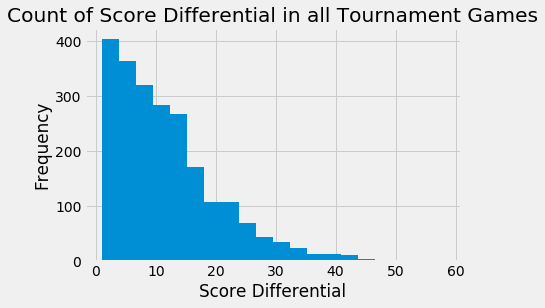

In [17]:
# let's take a quick peak at the frequency of our score differentials of all Tournament Games.

df_merged['score_diff'].plot(kind = 'hist', bins = 20, label = "Score Differential")
plt.title('Count of Score Differential in all Tournament Games')
plt.xlabel('Score Differential')
plt.show()

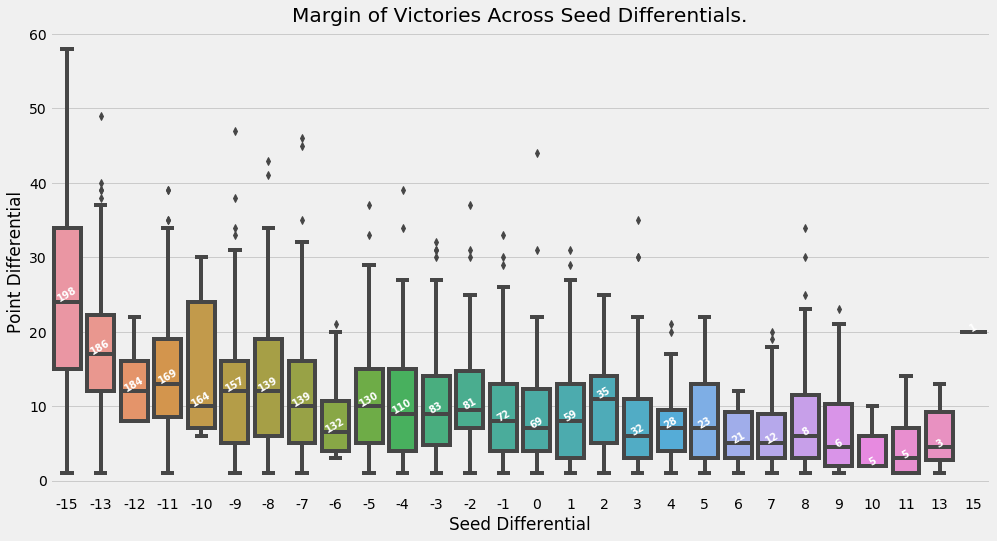

In [19]:
# That was low hanging fruit.  Lets look at how margin of victory changes by seed differential

# doing a little data prep to graph winshares by seed differential.
y = df_merged['seed_diff'].value_counts().sort_index().values.tolist()
# can't have 14 seed diff
y.insert(1, 0)
y.insert(28, 0)
y.insert(27, 0)

fig=plt.figure(figsize = (15,8))
ax = sns.boxplot(x="seed_diff", y="score_diff", data=df_merged)
ax.set_xlabel('Seed Differential')
ax.set_ylabel('Point Differential')
ax.set_title('Margin of Victories Across Seed Differentials.')

# Calculate number of observations per group & where to position labels
medians = df_merged.groupby(['seed_diff'])['score_diff'].median().values
nobs = df_merged['seed_diff'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = [i for i in nobs] 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
    horizontalalignment='center', size='x-small', color='w', weight='semibold', rotation = 30)
 
plt.show()


In [22]:
# apply our DayNum conversion so we can seperate by round

df_merged['Round'] = df_merged.DayNum.apply(convertRound)

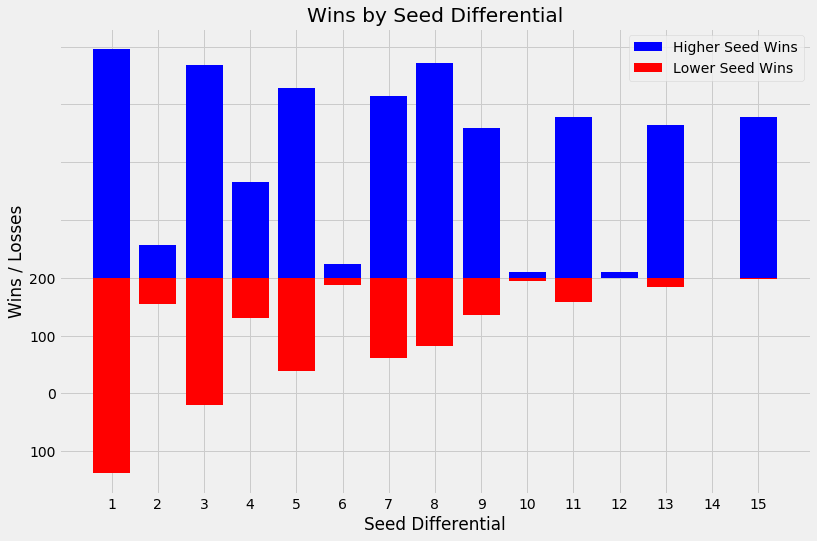

In [28]:
# need a little ninjitsu to count wins by higher and lower seeded team by seed differential

hs_wins_count = []
ls_wins_count = []
for i in range(31):
    if (i<15):
        hs_wins_count.append(y[i])
    elif (i>15):
        ls_wins_count.append(y[i]*-1)
ls_wins_count.reverse()

# the plot itself.

x = range(15, 0, -1)
label = ['Higher Seed Wins', 'Lower Seed Wins']
fig = plt.figure(figsize = (12,8))
ax = plt.subplot(111)
ax.bar(x, hs_wins_count, color = 'b')
ax.bar(x, ls_wins_count, color = 'r')
ax.set_xticks(x)
ax.set_yticklabels(('200', '100', '0', '100', '200'))
ax.legend(label, loc = 'best')
ax.set_xlabel('Seed Differential')
ax.set_ylabel('Wins / Losses')
plt.title("Wins by Seed Differential")
plt.show()

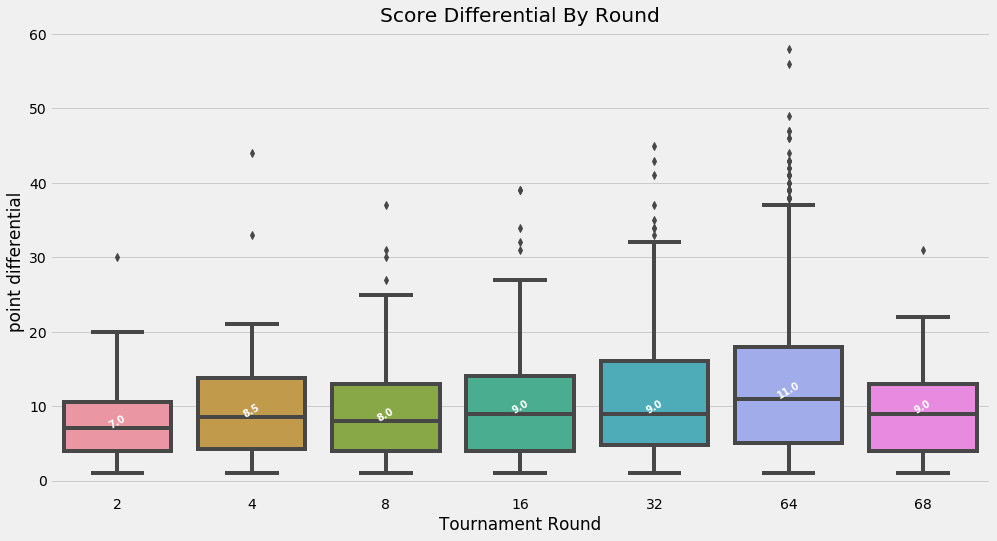

In [29]:
# Does score differential change by round?  Regardless of matchup?

# score differential by round
fig=plt.figure(figsize = (15,8))
ax = sns.boxplot(x="Round", y="score_diff", data=df_merged)
#ax.scatter(grades_range, boys_grades, color='b')
ax.set_xlabel('Tournament Round')
ax.set_ylabel('point differential')
ax.set_title('Score Differential By Round')

# Calculate number of observations per group & where to position labels
medians = df_merged.groupby(['Round'])['score_diff'].median().values
nobs = medians
nobs = [str(x) for x in nobs.tolist()]
nobs = [i for i in nobs] 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
    horizontalalignment='center', size='x-small', color='w', weight='semibold', rotation = 30)
 
plt.show()

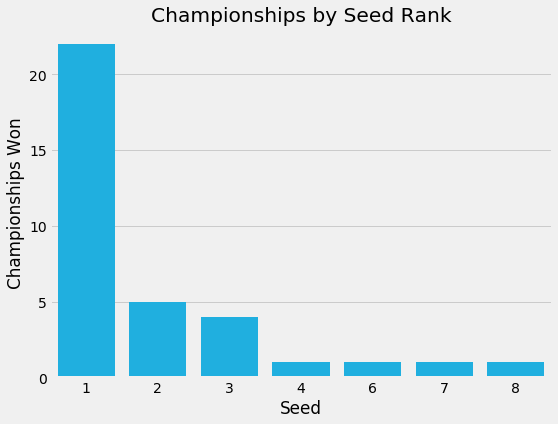

In [30]:

# Which seeds win the championships?

fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(df_merged[df_merged.Round == 2].WSeed, color = carolinaBlue)
ax.set_title("Championships by Seed Rank")
ax.set_xlabel("Seed")
ax.set_ylabel("Championships Won")
plt.show()


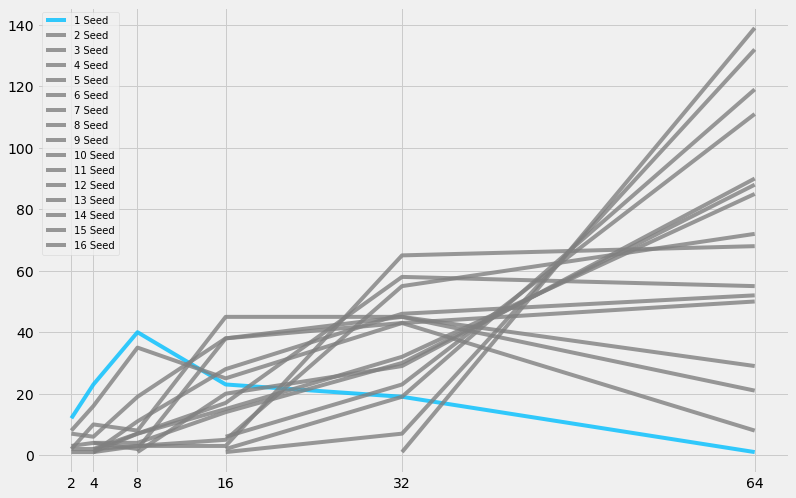

In [35]:
# score differential by round

df_facet = df_merged
df_facet = df_facet[df_facet["Round"]<68]
plt.figure(figsize=(12,8))
for i in range(1,17):
    df_dummy = df_facet[df_facet['LSeed'] == i]
    df = df_dummy.Round.value_counts()
    if (i == 1):
        plot_color = carolinaBlue
    else:
        plot_color = 'grey'
    ax = sns.lineplot(df.index, df.values, alpha=0.8, color = plot_color, label = ('%d Seed' % i))
    
ax.set(xticks=(64, 32, 16, 8, 4, 2))
plt.legend(fontsize = 10)

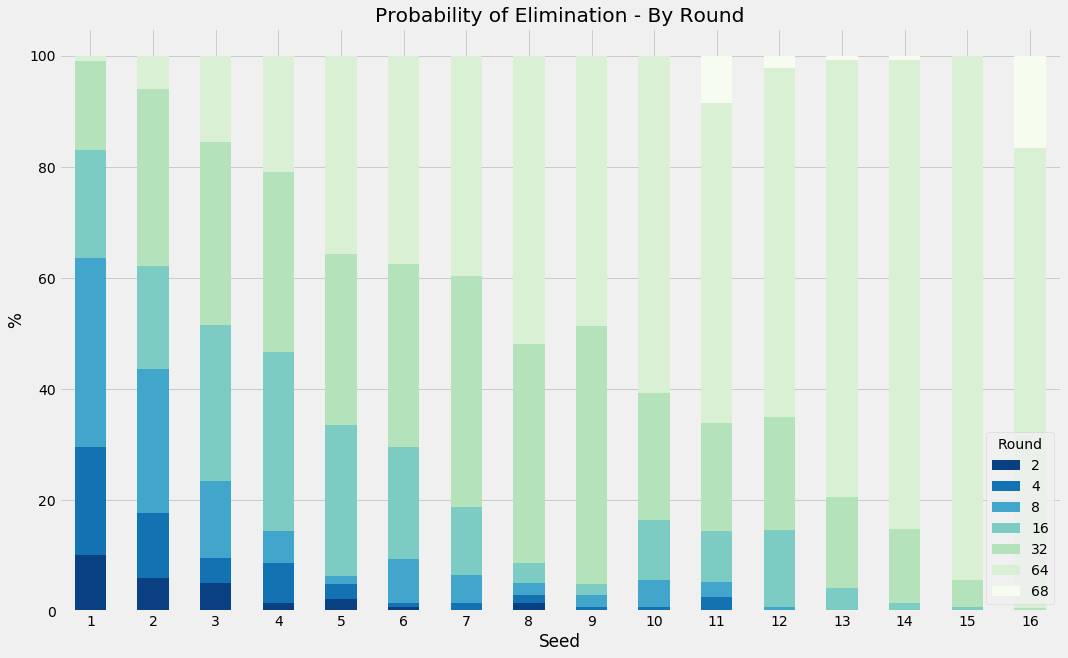

In [36]:
# by seed, when are you likely to be eliminated?

ax= pd.crosstab(df_merged['LSeed'], df_merged['Round']).apply(lambda r: r/r.sum()*100, axis=1)
ax.plot.bar(figsize=(16,10),stacked=True, rot=0,cmap = 'GnBu_r')

plt.legend(loc='best',title="Round")

plt.xlabel('Seed')
plt.ylabel('%')
plt.title('Probability of Elimination - By Round')

plt.show()

Summary:  
    
It seems the selection council in general does pretty well as the 1seeds win it all more than all other seeds combined.

Additionally, no 9-seed or higher has never won the tournament.  In fact the 9 seeds seem to generally lose by the round of 32 and are generally outperformed by 10, 11 and 12 seeds.  



Lets take a look at team by team comparisons

In [97]:
df = pd.read_csv('CreatedData/Advanced_stats_Reg_Season_All_Games.csv')

In [120]:
# lets take a look at each teams average.
# and do some cleanup

team_averages = df.groupby(['TeamID','Season']).mean().reset_index()
team_averages = team_averages.drop(columns = ['Unnamed: 0', 'Season', 'TeamID', 'Score', 'NumOT', 'FGM', 'FGA',
       'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Rtg_Margin', 
       'Round_2', 'Round_4', 'Round_8', 'Round_16', 'Round_32', 'Round_64',
       'Round_68'])
team_averages.columns

Index(['Ast', 'TO', 'Stl', 'Blk', 'PF', 'Possessions', 'Shooting_Eff',
       'EffectiveFGP', 'FGP3', 'Off_Rating', 'Def_Rating', 'Off_RBP',
       'Def_RBP', 'Tot_RBP', 'TO_Rate', 'FTP', 'Ast_Ratio', 'Blk_Ratio',
       'Stl_Ratio', 'win'],
      dtype='object')

In [123]:
basics = team_averages.drop(columns = ['Possessions', 'Shooting_Eff',
       'EffectiveFGP', 'FGP3', 'Off_Rating', 'Def_Rating', 'Off_RBP',
       'Def_RBP', 'Tot_RBP', 'TO_Rate'])
advanced = team_averages.drop(columns = ['Ast', 'TO', 'Stl', 'Blk', 'PF', 'FTP', 'Ast_Ratio', 'Blk_Ratio',
       'Stl_Ratio', 'win'])

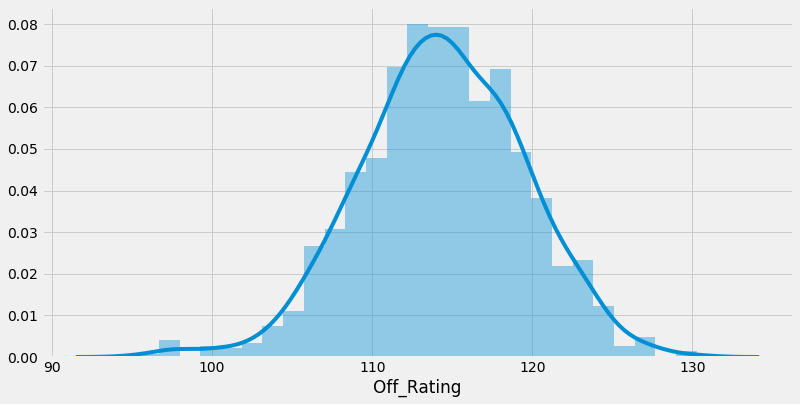

In [106]:
plt.figure(figsize=(12,6))
sns.distplot(team_averages['Off_Rating'])

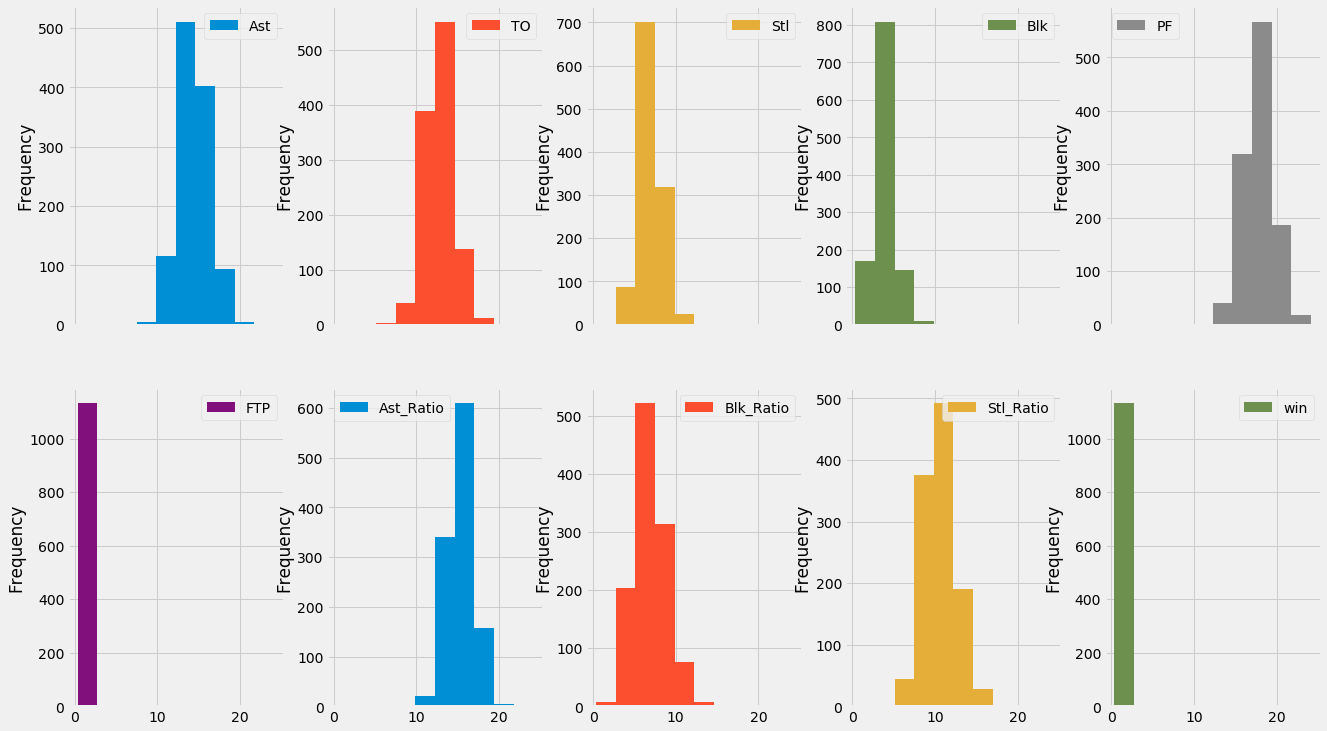

In [135]:
basics.plot.hist(subplots=True, figsize=(20,12), layout = (2,5))
plt.show()

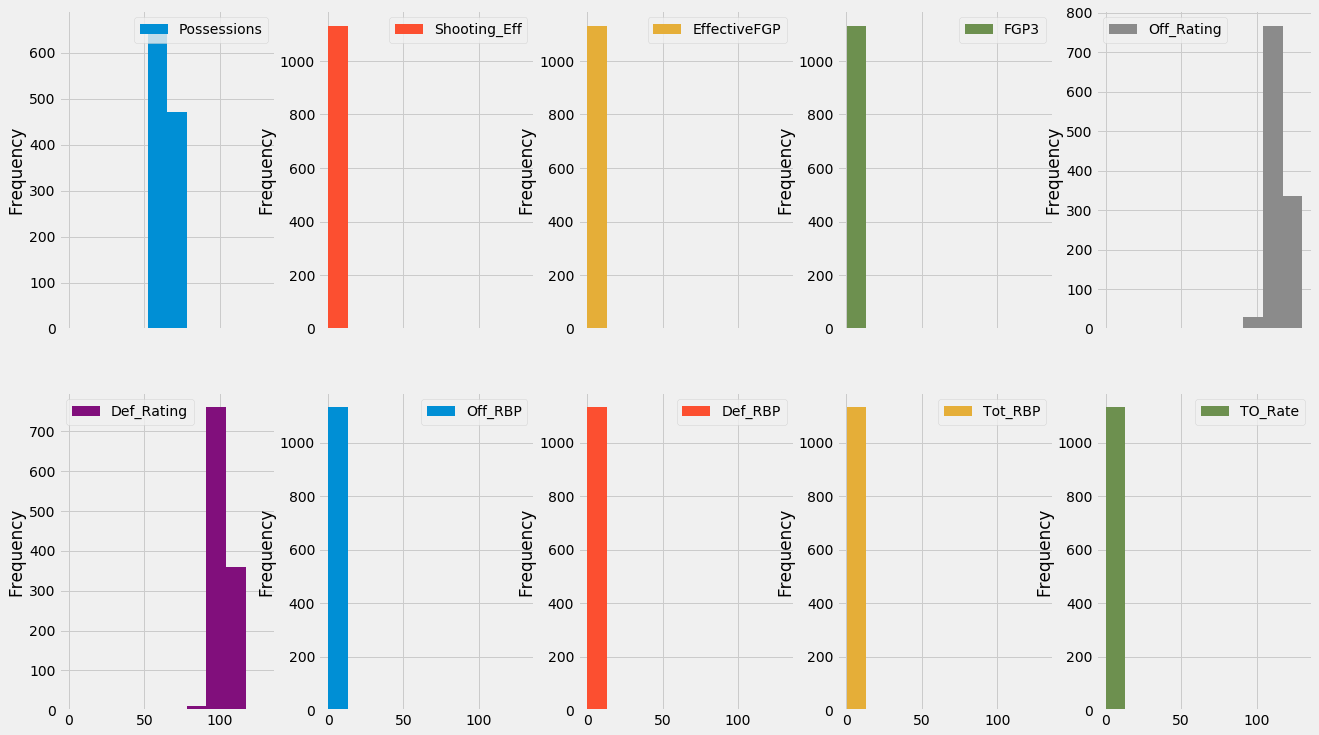

In [136]:
advanced.plot.hist(subplots=True, figsize=(20,12), layout = (2,5))
plt.show()